# Telco Customer Churn using Artificial Neural Networks

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

In [34]:
is_runGridSearch = False

## User Defined Functions

Heatmaps of confusion matrix

In [35]:
def fn_plot_confusionMatrix(cm,titles):
    fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
    k = 0
    for i in ax:
        for j in i:
            sn.heatmap(cm[k], annot=True, 
                   fmt='d', 
                   xticklabels=np.sort(y_train.Churn.astype("int").unique()), 
                   yticklabels=np.sort(y_train.Churn.astype("int").unique()), 
                   ax=j)
            j.set_title(titles[k])
            j.set_xlabel("Prediction")
            j.set_ylabel("Actual")
            k = k + 1 
    return plt

Metrics of a classification problem

In [36]:
def fn_metrics(cm_):
    met_=[]
    for i in cm_:
        true_pos = i[1][1]
        true_neg = i[0][0]
        false_pos = i[0][1]
        false_neg = i[1][0]
        accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = true_pos /(true_pos+false_pos)
        recall = true_pos/(true_pos+false_neg)
        f1_score = 2*precision*recall/(precision+recall)
        met_.append(pd.DataFrame(data=[accuracy,precision,recall,f1_score],index=["accuracy","precision","recall","f1_score"]))
    return met_

## Importing the file

In [37]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [38]:
master_dataset.describe(include = 'all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,1724-IQWNM,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [39]:
master_dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [40]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Data Preprocessing and EDA

Dropping customerID and TotalCharges

customerID is an unique identifier which doesn't help in building predictive model

TotalCharges is most likely a  derived column from Tenure and Monthly Charges

Converting SeniorCitizen to catgeory

In [41]:
master_dataset.drop("customerID", axis = 1, inplace=True)
master_dataset.drop("TotalCharges", axis = 1,  inplace=True)
master_dataset["SeniorCitizen"] = master_dataset["SeniorCitizen"].astype("category")

In [42]:
lc = LabelEncoder()
for i in master_dataset.columns:
    if(master_dataset[i].dtype.name=="object"):
        master_dataset[i] = master_dataset[i].astype("category")
        master_dataset[i] = lc.fit_transform(master_dataset[i])
        master_dataset[i] = master_dataset[i].astype("category")
        
# master_dataset.head(7)
master_dataset.dtypes

gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
Churn               category
dtype: object

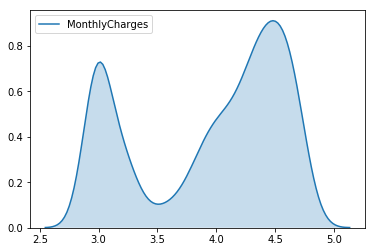

In [43]:
sn.kdeplot(np.log(master_dataset[master_dataset["Churn"]==0]["MonthlyCharges"]), shade=True)

### Examining relationship between MonthlyCharges and tenure for Churn

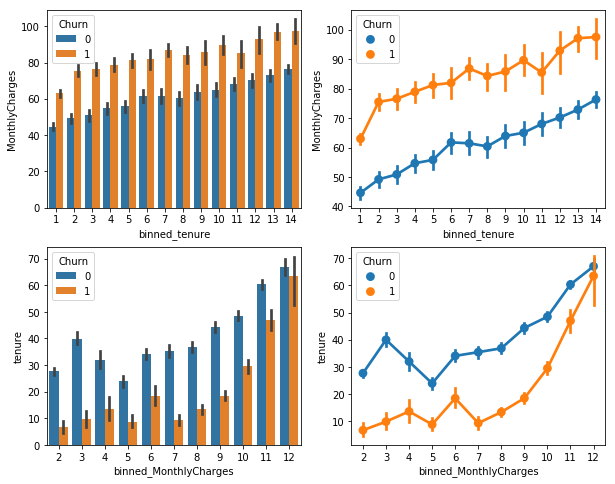

In [45]:
bins = np.linspace(0, 100, 20)
master_dataset["binned_tenure"] = np.digitize(master_dataset["tenure"], bins)

bins = np.linspace(0, 200, 20)
master_dataset["binned_MonthlyCharges"] = np.digitize(master_dataset["MonthlyCharges"], bins)

master_dataset.head()

fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
sn.barplot(y="MonthlyCharges",x="binned_tenure",hue="Churn",data=master_dataset, ax=ax[0][0])
sn.pointplot(y="MonthlyCharges",x="binned_tenure",hue="Churn",data=master_dataset,ax=ax[0][1])
sn.barplot(y="tenure",x="binned_MonthlyCharges",hue="Churn",data=master_dataset, ax=ax[1][0])
sn.pointplot(y="tenure",x="binned_MonthlyCharges",hue="Churn",data=master_dataset,ax=ax[1][1])

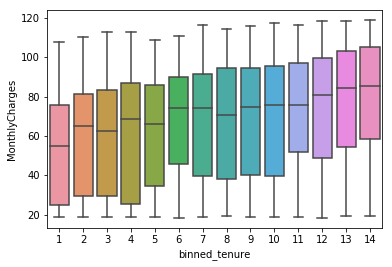

In [46]:
sn.boxplot(y="MonthlyCharges",x="binned_tenure",data=master_dataset)


In [47]:
mean_MCharges = master_dataset[["binned_tenure","MonthlyCharges","Churn"]].groupby(["binned_tenure","Churn"])["MonthlyCharges"].median().unstack()
mean_MCharges = pd.DataFrame(mean_MCharges)
mean_MCharges.columns = ["Churn_No","Churn_Yes"]

master_dataset["binned_tenure"] = master_dataset["binned_tenure"].astype("object")
y=mean_MCharges
y.dtypes
master_dataset = pd.merge(master_dataset,y, left_on="binned_tenure", right_index=True)

master_dataset["Probable_Churn_Class"] = np.where(abs(master_dataset["MonthlyCharges"]-master_dataset["Churn_No"])>=abs(master_dataset["MonthlyCharges"]-master_dataset["Churn_Yes"]), 1, 0)                                       
# master_dataset.drop("Churn_No",axis=1,inplace=True)
# master_dataset.drop("Churn_Yes",axis=1,inplace=True)


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [46]:
# mean_MCharges = master_dataset[["binned_tenure","binned_MonthlyCharges","Churn"]].groupby(["binned_tenure","Churn"])["binned_MonthlyCharges"].agg(lambda x:x.value_counts().index[0]).unstack()
# mean_MCharges = pd.DataFrame(mean_MCharges)
# mean_MCharges.columns = ["Churn_No","Churn_Yes"]

# mean_MCharges.head()

# master_dataset["binned_tenure"] = master_dataset["binned_tenure"].astype("object")
# y=mean_MCharges
# y.dtypes
# master_dataset = pd.merge(master_dataset,y, left_on="binned_tenure", right_index=True)

# master_dataset["Probable_Churn_Class"] = np.where(abs(master_dataset["binned_MonthlyCharges"]-master_dataset["Churn_No"])>=abs(master_dataset["binned_MonthlyCharges"]-master_dataset["Churn_Yes"]), 1, 0)                                       
# # master_dataset.drop("Churn_No",axis=1,inplace=True)
# # master_dataset.drop("Churn_Yes",axis=1,inplace=True)


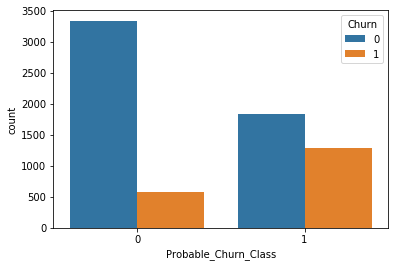

In [48]:
sn.countplot(x="Probable_Churn_Class", hue="Churn", data=master_dataset)

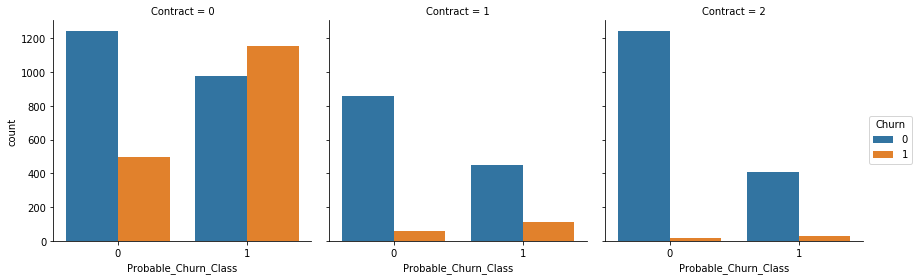

In [50]:
sn.factorplot(x="Probable_Churn_Class", hue="Churn", col="Contract", data=master_dataset, kind="count")

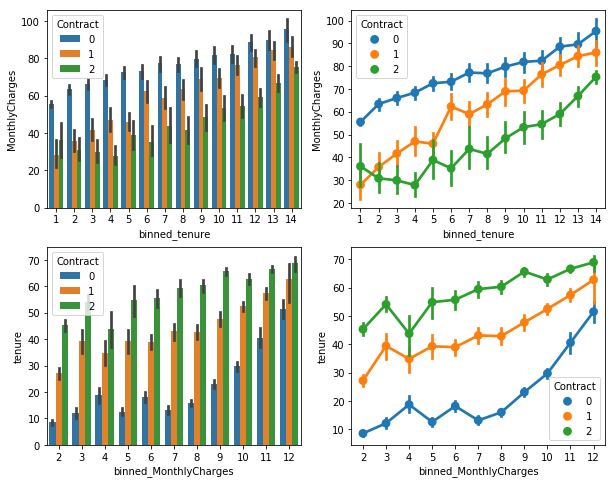

In [51]:
bins = np.linspace(0, 100, 20)
master_dataset["binned_tenure"] = np.digitize(master_dataset["tenure"], bins)

bins = np.linspace(0, 200, 20)
master_dataset["binned_MonthlyCharges"] = np.digitize(master_dataset["MonthlyCharges"], bins)

master_dataset.head()

fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
sn.barplot(y="MonthlyCharges",x="binned_tenure",hue="Contract",data=master_dataset, ax=ax[0][0])
sn.pointplot(y="MonthlyCharges",x="binned_tenure",hue="Contract",data=master_dataset,ax=ax[0][1])
sn.barplot(y="tenure",x="binned_MonthlyCharges",hue="Contract",data=master_dataset, ax=ax[1][0])
sn.pointplot(y="tenure",x="binned_MonthlyCharges",hue="Contract",data=master_dataset,ax=ax[1][1])

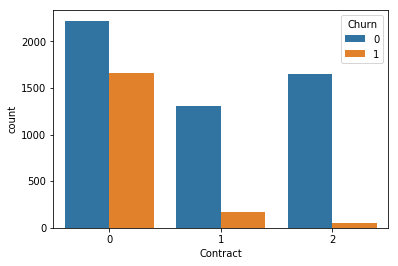

In [52]:
sn.countplot(x="Contract", hue="Churn", data=master_dataset)

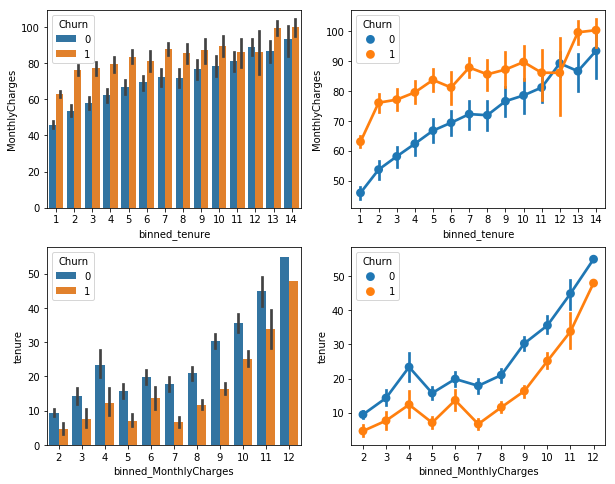

In [53]:
data=master_dataset[(master_dataset["Contract"]==0)]
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
sn.barplot(y="MonthlyCharges",x="binned_tenure",hue="Churn",data=data, ax=ax[0][0])
sn.pointplot(y="MonthlyCharges",x="binned_tenure",hue="Churn",data=data,ax=ax[0][1])
sn.barplot(y="tenure",x="binned_MonthlyCharges",hue="Churn",data=data, ax=ax[1][0])
sn.pointplot(y="tenure",x="binned_MonthlyCharges",hue="Churn",data=data,ax=ax[1][1])

In [54]:
master_dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,binned_tenure,binned_MonthlyCharges,Churn_No,Churn_Yes,Probable_Churn_Class
0,0,0,1,0,1,0,1,0,0,2,...,0,1,2,29.85,0,1,3,44.6,70.15,0
2,1,0,0,0,2,1,0,0,2,2,...,0,1,3,53.85,1,1,6,44.6,70.15,0
4,0,0,0,0,2,1,0,1,0,0,...,0,1,2,70.70,1,1,7,44.6,70.15,1
20,1,1,0,0,1,0,1,0,0,0,...,0,1,2,39.65,1,1,4,44.6,70.15,0
22,1,0,0,0,1,1,0,2,1,1,...,0,0,3,20.15,1,1,2,44.6,70.15,0


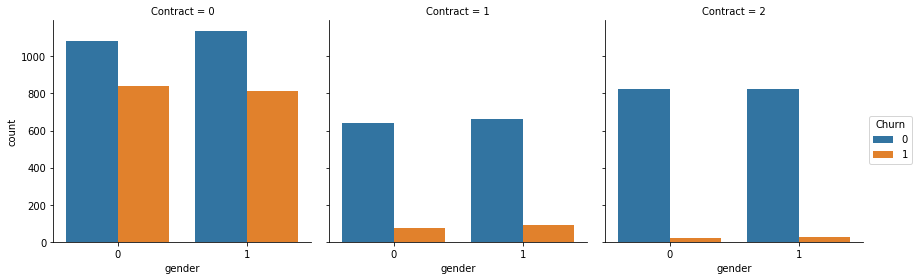

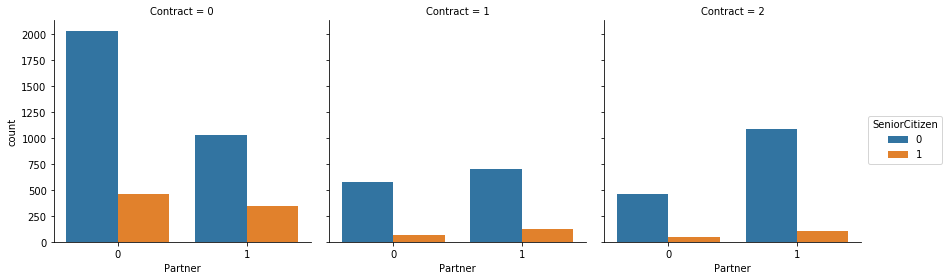

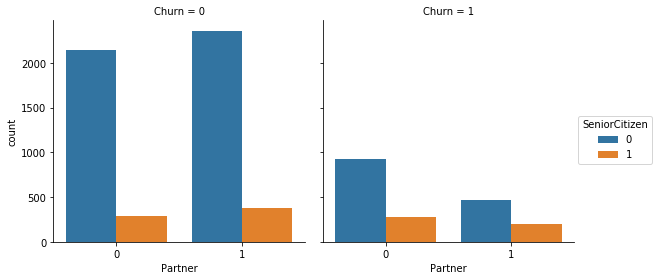

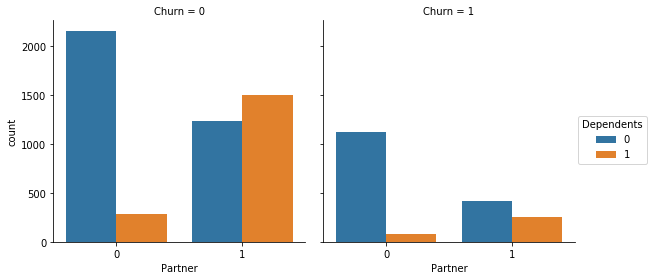

In [55]:
# data=master_dataset[(master_dataset["Contract"]==0)]
# fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
# sn.countplot(y="Churn",x="gender",data=data, ax=ax[0][0])
# sn.countplot(y="Partner",x="SeniorCitizen",hue="Churn",data=data,ax=ax[0][1])
# sn.countplot(y="Partner",x="Dependents",hue="Churn",data=data, ax=ax[1][0])
# sn.countplot(y="SeniorCitizen",x="Dependents",hue="Partner",data=data,ax=ax[1][1])

sn.factorplot(x="gender", hue="Churn", col="Contract", data=master_dataset, kind="count")
sn.factorplot(x="Partner", hue="SeniorCitizen", col="Contract", data=master_dataset, kind="count")
sn.factorplot(x="Partner", hue="SeniorCitizen", col="Churn", data=master_dataset, kind="count")
sn.factorplot(x="Partner", hue="Dependents", col="Churn", data=master_dataset, kind="count")

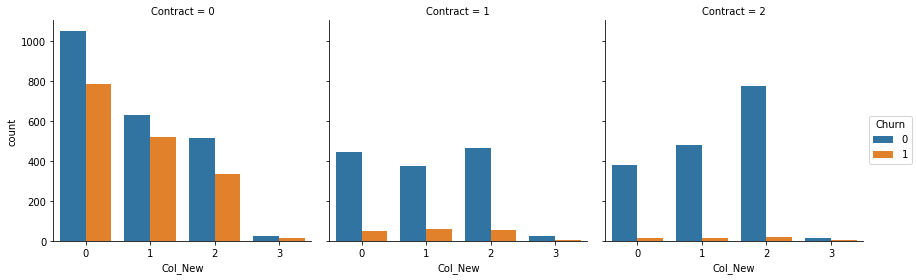

In [56]:
master_dataset["Col_New"] = master_dataset["Partner"].astype("int64") + master_dataset["SeniorCitizen"].astype("int64") + master_dataset["Dependents"].astype("int64")
master_dataset["Col_New"] = master_dataset["Col_New"].astype("category")
sn.factorplot(x="Col_New", hue="Churn", col="Contract", data=master_dataset, kind="count")
master_dataset.drop("Col_New",axis=1,inplace=True)

In [57]:
master_dataset.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn', 'binned_tenure', 'binned_MonthlyCharges',
       'Churn_No', 'Churn_Yes', 'Probable_Churn_Class'],
      dtype='object')

In [58]:
master_dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,binned_tenure,binned_MonthlyCharges,Churn_No,Churn_Yes,Probable_Churn_Class
0,0,0,1,0,1,0,1,0,0,2,...,0,1,2,29.85,0,1,3,44.6,70.15,0
2,1,0,0,0,2,1,0,0,2,2,...,0,1,3,53.85,1,1,6,44.6,70.15,0
4,0,0,0,0,2,1,0,1,0,0,...,0,1,2,70.70,1,1,7,44.6,70.15,1
20,1,1,0,0,1,0,1,0,0,0,...,0,1,2,39.65,1,1,4,44.6,70.15,0
22,1,0,0,0,1,1,0,2,1,1,...,0,0,3,20.15,1,1,2,44.6,70.15,0


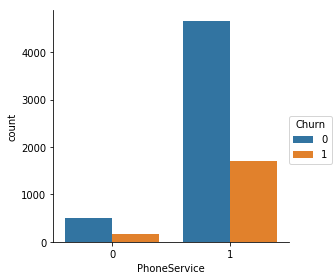

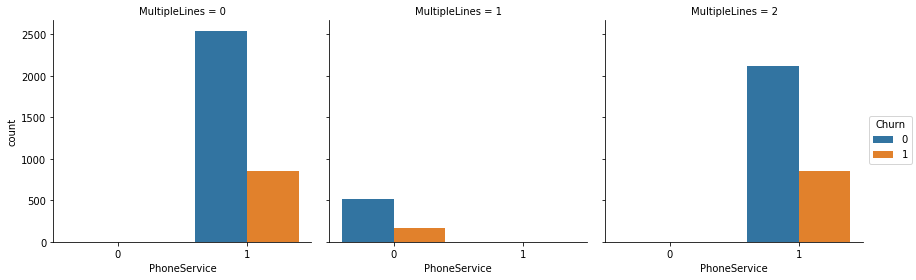

In [59]:
sn.factorplot(x="PhoneService", hue="Churn", data=master_dataset, kind="count")
sn.factorplot(x="PhoneService", col="MultipleLines", hue="Churn", data=master_dataset, kind="count")

In [58]:
# master_dataset["TotalCharges"] = master_dataset["tenure"]*master_dataset["MonthlyCharges"]
# master_dataset.drop("tenure", axis = 1,  inplace=True)
# master_dataset.drop("MonthlyCharges", axis = 1,  inplace=True)
# master_dataset.drop("binned_tenure", axis = 1,  inplace=True)
# master_dataset.drop("binned_MonthlyCharges", axis = 1,  inplace=True)

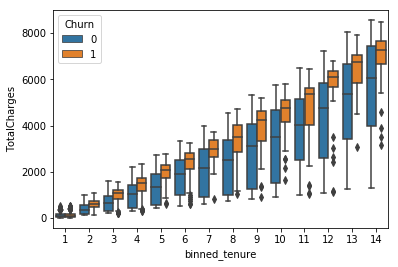

In [60]:
master_dataset["TotalCharges"] = master_dataset["tenure"]*master_dataset["MonthlyCharges"]
sn.boxplot(y="TotalCharges",x="binned_tenure",hue="Churn",data=master_dataset)


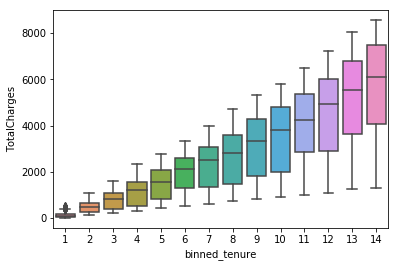

In [61]:
sn.boxplot(y="TotalCharges",x="binned_tenure",data=master_dataset)

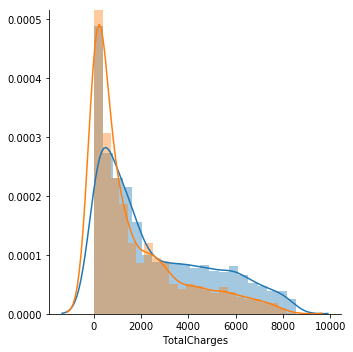

In [26]:
sn.FacetGrid(master_dataset, hue="Churn", size=5).map(sn.distplot, "TotalCharges") 
plt.show();

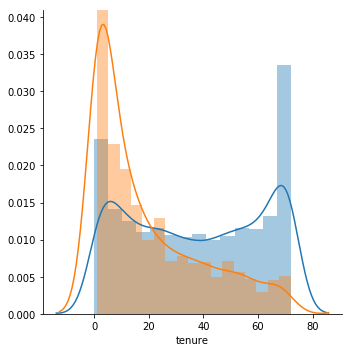

In [92]:
sn.FacetGrid(master_dataset, hue="Churn", size=5).map(sn.distplot, "tenure") 
plt.show();

In [74]:
def fn_get_per_val(x,y,z):
    if x<=y and x<z:
        return y
    elif x>=z and x>z:
        return z
    return x

In [78]:
res = master_dataset.groupby("binned_tenure")["TotalCharges"].quantile([0.25, 0.75]).unstack(level=1)
res = pd.DataFrame(res)
res.columns = ["t_","t__"]
res.head()
master_dataset = pd.merge(master_dataset,res,left_on="binned_tenure", right_index=True)
# master_dataset["rm_outlier_TotalCharges"] = master_dataset.apply(fn_get_per_val, master_dataset)
# master_dataset.apply(fn_get_per_val,master_dataset["TotalCharges"],master_dataset["t_"],master_dataset["t__"])

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


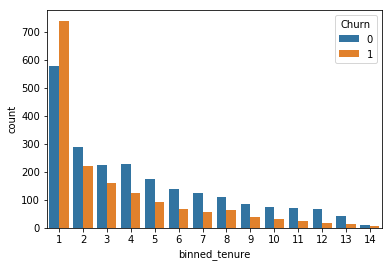

In [27]:
sn.countplot(x="binned_tenure",hue="Churn",data=data)

In [62]:
oe = OneHotEncoder()
master_dataset_cat=[]
master_dataset_ncat=[]
for i in master_dataset.columns:
    if(master_dataset[i].dtype.name=="category"):
        if(len(master_dataset[i].unique()) > 2):
            master_dataset_cat.append(i)
        else:
            master_dataset_ncat.append(i)  
    else:
        master_dataset_ncat.append(i)
# master_dataset_cat.remove("Contract")                 
master_dataset_cat = master_dataset[master_dataset_cat]
master_dataset_ncat = master_dataset[master_dataset_ncat]
master_dataset_ncat.head(4)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,binned_tenure,binned_MonthlyCharges,Churn_No,Churn_Yes,Probable_Churn_Class,TotalCharges
0,0,0,1,0,1,0,1,29.85,0,1,3,44.6,70.15,0,29.85
2,1,0,0,0,2,1,1,53.85,1,1,6,44.6,70.15,0,107.70
4,0,0,0,0,2,1,1,70.70,1,1,7,44.6,70.15,1,141.40
20,1,1,0,0,1,0,1,39.65,1,1,4,44.6,70.15,0,39.65


In [63]:
# oe.fit_transform(master_dataset_cat).toarray()
master_dataset_cat = pd.get_dummies(master_dataset_cat,drop_first=False)
master_dataset_cat.head(5)

,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,...,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,0,1,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
20,0,1,0,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,1,0
22,1,0,0,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1


In [64]:
fn_dataset = pd.merge(master_dataset_cat,master_dataset_ncat,left_index=True, right_index=True)
X = fn_dataset.drop("Churn", axis=1)
Y = fn_dataset.loc[:,["Churn"]]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0)

## Decison Tree

In [66]:
dtree_model = DecisionTreeClassifier().fit(X_train, y_train)
dtree_predictions_test = dtree_model.predict(X_test)
dtree_predictions_train = dtree_model.predict(X_train)

In [490]:
dtree_model = DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)
dtree_predictions_test = dtree_model.predict(X_test)
dtree_predictions_train = dtree_model.predict(X_train)

In [67]:
pd.DataFrame(dtree_model.feature_importances_,index=X.columns).sort_values(0, ascending=False)

,0
MonthlyCharges,0.179688
Contract_0,0.166636
TotalCharges,0.163021
tenure,0.113044
InternetService_1,0.055746
gender,0.034826
SeniorCitizen,0.025472
PaperlessBilling,0.022532
OnlineSecurity_0,0.021012
Partner,0.018014


In [532]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

KeyboardInterrupt: 

In [68]:
dtree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [69]:
cm_pred_test = confusion_matrix(y_test, dtree_predictions_test)
cm_pred_train = confusion_matrix(y_train, dtree_predictions_train)
cm_act_train = confusion_matrix(y_train, y_train)
cm_act_test = confusion_matrix(y_test, y_test)
cm = [cm_act_train, cm_pred_train, cm_act_test, cm_pred_test ]
titles = ["Actual Train","Prediction Train","Actual Test","Precition Test"]

In [70]:
classificaiton_report_train=classification_report(y_train,dtree_predictions_train)
print(classificaiton_report_train)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3849
          1       1.00      0.99      0.99      1433

avg / total       1.00      1.00      1.00      5282



In [71]:
classificaiton_report_test=classification_report(y_test,dtree_predictions_test)
print(classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.83      0.81      0.82      1325
          1       0.47      0.51      0.49       436

avg / total       0.74      0.73      0.74      1761



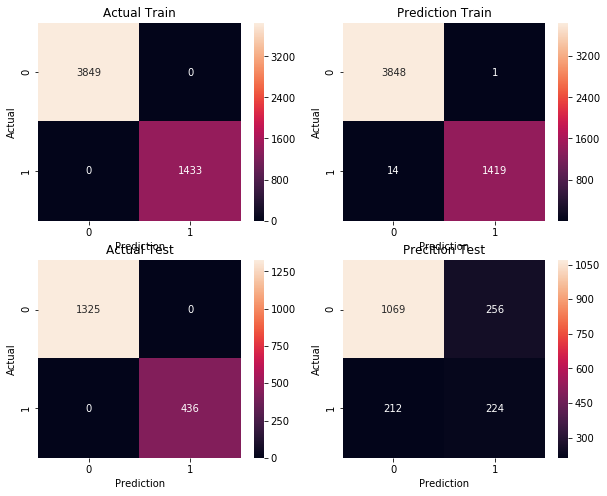

In [72]:
fn_plot_confusionMatrix(cm,titles).show()

## Metrics

In [498]:
cm_ = [cm_pred_train, cm_pred_test ]
met_ = fn_metrics(cm_)

Train Dataset

In [499]:
met_[0]

,0
accuracy,0.955131
precision,0.934439
recall,0.892086
f1_score,0.912771


Test Dataset

In [500]:
met_[1]

,0
accuracy,0.718342
precision,0.481953
recall,0.473904
f1_score,0.477895


## Grid Search

In [64]:
if(is_runGridSearch):
    dtree_model = DecisionTreeClassifier()
    parameters = {
        'max_depth':[5,7,9,12],
        'max_features':[3,5,7,9,11,13,15,18,20,25,27,30],
        'max_leaf_nodes':[10,20,30,40],
        'min_samples_split':[20,30,40,50,60,70],
        'min_samples_leaf':[2,5,8,12,15,18,20,25,30,35,40],
        'splitter':['best','random'],
        'criterion':['gini','entropy']
    }
    gsv = GridSearchCV(dtree_model, parameters,n_jobs=3 )
    # gsv = GridSearchCV(dtree_model, parameters, verbose=0)
    gsv.fit(X_train, y_train)
    dtree_predictions_test = gsv.predict(X_test)
    dtree_predictions_train = gsv.predict(X_train)
    gsv.best_params_


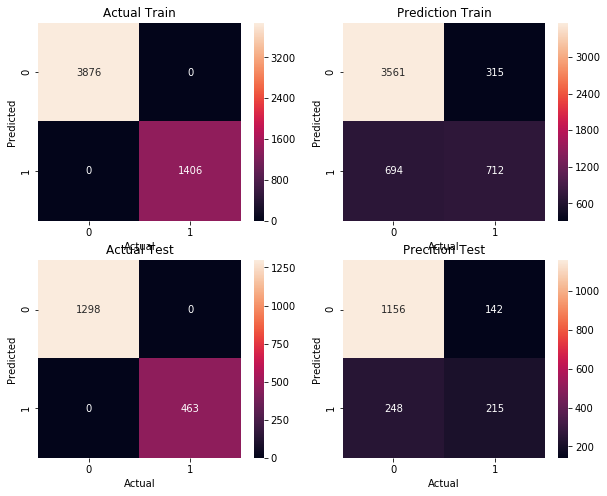

In [58]:
cm_pred_test = confusion_matrix(y_test, dtree_predictions_test)
cm_pred_train = confusion_matrix(y_train, dtree_predictions_train)
cm_act_train = confusion_matrix(y_train, y_train)
cm_act_test = confusion_matrix(y_test, y_test)
cm = [cm_act_train, cm_pred_train, cm_act_test, cm_pred_test ]
titles = ["Actual Train","Prediction Train","Actual Test","Precition Test"]
fn_plot_confusionMatrix(cm,titles).show()

In [59]:
cm_ = [cm_pred_train, cm_pred_test ]
for i in cm_:
    true_pos = i[0][0]
    true_neg = i[1][1]
    false_pos = i[1][0]
    false_neg = i[0][1]
    accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
    precision = true_pos /(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    f1_score = 2*precision*recall/(precision+recall)
    met_.append(pd.DataFrame(data=[accuracy,precision,recall,f1_score],index=["accuracy","precision","recall","f1_score"]))
met_ = fn_metrics(cm_)

## Metrics

#### Train Dataset

In [60]:
met_[0]

,0
accuracy,0.808974
precision,0.836898
recall,0.918731
f1_score,0.875907


#### Test Dataset

In [61]:
met_[1]

,0
accuracy,0.778535
precision,0.823362
recall,0.890601
f1_score,0.855662


## Artifical Neural Network

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape

In [ ]:

classifier = Sequential()

classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer = 'uniform', input_dim = 39))
classifier.add(Dropout(rate = 0.1))

classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer = 'uniform'))
classifier.add(Dropout(rate = 0.1))

classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 5, epochs = 20)



In [ ]:
y_pred = classifier.predict(X_train) > 0.4
from sklearn.metrics import confusion_matrix
cm_pred_train = confusion_matrix(y_train, y_pred)
cm_act_train = confusion_matrix(y_train, y_train)

y_pred = classifier.predict(X_test) > 0.4
from sklearn.metrics import confusion_matrix
cm_pred_test = confusion_matrix(y_test, y_pred)
cm_act_test = confusion_matrix(y_test, y_test)
cm = [cm_act_train , cm_pred_train , cm_act_test , cm_pred_test]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
k = 0
for i in ax:
    for j in i:
        sn.heatmap(cm[k], annot=True, 
               fmt='d', 
               xticklabels=np.sort(y_train.Churn.astype("int").unique()), 
               yticklabels=np.sort(y_train.Churn.astype("int").unique()), 
               ax=j)
        j.set_title(titles[k])
        j.set_xlabel("Actual")
        j.set_ylabel("Predicted")
        k = k + 1 
plt.show()
   